## 1. Introduction

This dataset contains ~5000 records merged from five publicly available heart disease datasets. It includes 12 features that are crucial for predicting  stroke . Below is a detailed description of each feature.

from kaggle (https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)

Attribute Information
1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke: 1 if the patient had a stroke or 0 if not


# <span style="color:blue"> Vamilla GAN adaptation </span>

For the vanilla gan I used this implementation and adapted it to my dataset
https://github.com/safwankdb/Vanilla-GAN/blob/master/Vanilla_GAN.ipynb

## <span style="color: #00509e;">Import Libraries  </span>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

## <span style="color: #00509e;"> Load & Preprocess the Dataset </span>

for feature selection i used 2 tests 

1) Cramér's V This will measure strength of association between each categorical feature and the binary target stroke

    1.Cramér's V between gender and stroke: 0.000

    2.Cramér's V between ever_married and stroke: 0.106

    3.Cramér's V between work_type and stroke: 0.094

    4.Cramér's V between Residence_type and stroke: 0.004

    5.Cramér's V between smoking_status and stroke: 0.072
Values close to 0 mean little to no association, values near 1 mean strong association. No strong categorical association with stroke

2)Chi-square to check if any of these features are statistically significant, even if the strength is low
        
    1.Chi-square test for gender: p-value = 0.7895
        
    2.Chi-square test for ever_married: p-value = 0.0000
       
    3.Chi-square test for work_type: p-value = 0.0000
        
    4.Chi-square test for Residence_type: p-value = 0.2983
      
    5.Chi-square test for smoking_status: p-value = 0.0000
If p < 0.05, the feature is likely related to stroke ever_married, work_type, and smoking_status are statistically associated with stroke gender and residence_type have no significant association with stroke

Minority class samples: 209

Stroke distribution:


stroke
0    4700
1     209
Name: count, dtype: int64

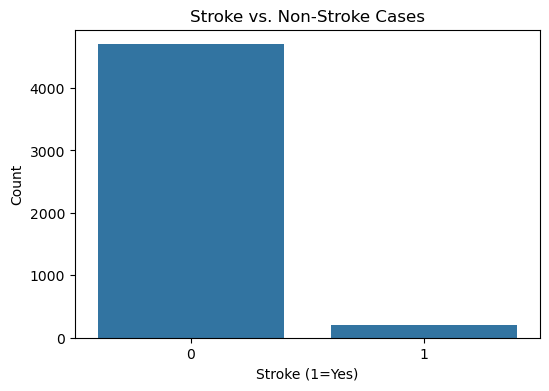

In [2]:
# Load the dataset
df = pd.read_csv("healthcare-dataset-stroke-data.csv",sep=";")

# Drop irrelevant or missing-value rows
df = df.drop(['id', 'gender', 'Residence_type'], axis=1)
df = df.dropna()

# Encode categorical variables
df['ever_married'] = df['ever_married'].map({'No': 0, 'Yes': 1})
df['work_type'] = df['work_type'].astype('category').cat.codes
df['smoking_status'] = df['smoking_status'].astype('category').cat.codes

# Extract the minority class (stroke == 1)
minority_df = df[df['stroke'] == 1].copy()
minority_df = minority_df.drop(['stroke'], axis=1)

# Normalize the features
scaler = MinMaxScaler()
minority_scaled = scaler.fit_transform(minority_df)

print("Minority class samples:", minority_scaled.shape[0])

print("\nStroke distribution:")
stroke_counts = df['stroke'].value_counts()
display(stroke_counts)
plt.figure(figsize=(6,4))
sns.barplot(x=stroke_counts.index, y=stroke_counts.values)
plt.title('Stroke vs. Non-Stroke Cases')
plt.xlabel('Stroke (1=Yes)')
plt.ylabel('Count')
plt.show()


We can see here that our dataset is strongly imbalance

## <span style="color: #00509e;"> Prepare DataLoader for GAN </span>

In [31]:
# Convert to PyTorch tensors
minority_tensor = torch.tensor(minority_scaled, dtype=torch.float32)

# Create DataLoader
batch_size = 32
dataset = TensorDataset(minority_tensor)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


## <span style="color: #00509e;">Define GAN Architecture </span>

In [32]:
input_dim = minority_scaled.shape[1]  # e.g., 10 features
latent_dim = 32  # noise vector size

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


## <span style="color: #00509e;">Initialize Models and Optimizers  </span>

In [33]:
generator = Generator()
discriminator = Discriminator()

criterion = nn.BCELoss()
lr = 0.0002

optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=lr)


## <span style="color: #00509e;">Train the GAN  </span>

In [34]:
import matplotlib.pyplot as plt

# Initialize lists to store loss values
g_losses = []
d_losses = []

epochs = 200
for epoch in range(epochs):
    total_d_loss = 0.0
    total_g_loss = 0.0
    batch_count = 0

    for real_batch, in data_loader:
        batch_size = real_batch.size(0)

        # === Train Discriminator ===
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        outputs = discriminator(real_batch)
        d_loss_real = criterion(outputs, real_labels)

        z = torch.randn(batch_size, latent_dim)
        fake_data = generator(z)
        outputs = discriminator(fake_data.detach())
        d_loss_fake = criterion(outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake

        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()

        # === Train Generator ===
        z = torch.randn(batch_size, latent_dim)
        fake_data = generator(z)
        outputs = discriminator(fake_data)
        g_loss = criterion(outputs, real_labels)

        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()

        # Accumulate batch losses
        total_d_loss += d_loss.item()
        total_g_loss += g_loss.item()
        batch_count += 1

    # Store average loss for the epoch
    avg_d_loss = total_d_loss / batch_count
    avg_g_loss = total_g_loss / batch_count
    d_losses.append(avg_d_loss)
    g_losses.append(avg_g_loss)

    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], d_loss: {avg_d_loss:.4f}, g_loss: {avg_g_loss:.4f}")


Epoch [20/200], d_loss: 1.3097, g_loss: 0.7230
Epoch [40/200], d_loss: 1.3467, g_loss: 0.6903
Epoch [60/200], d_loss: 1.3597, g_loss: 0.6863
Epoch [80/200], d_loss: 1.3410, g_loss: 0.7116
Epoch [100/200], d_loss: 1.3212, g_loss: 0.7594
Epoch [120/200], d_loss: 1.2912, g_loss: 0.7753
Epoch [140/200], d_loss: 1.2832, g_loss: 0.7402
Epoch [160/200], d_loss: 1.2887, g_loss: 0.7312
Epoch [180/200], d_loss: 1.3296, g_loss: 0.7434
Epoch [200/200], d_loss: 1.1900, g_loss: 0.8194


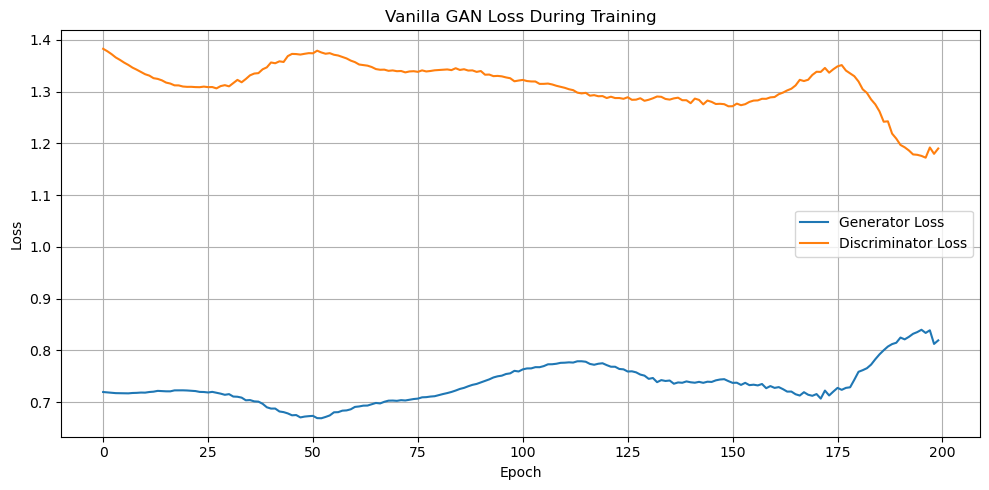

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Vanilla GAN Loss During Training")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("vanilla_gan_loss_curve.png")  # Optional
plt.show()


This plot shows the training loss for the generator and discriminator in a Vanilla GAN. The discriminator loss started high and gradually decreased, while the generator loss stayed relatively stable with some upward trend toward the end, indicating balanced competition. The smooth curves suggest stable training without major mode collapse or instability.

## <span style="color: #00509e;">Generate and Visualize Synthetic Data  </span>

In [36]:
# Generate synthetic data
z = torch.randn(4000, latent_dim)
synthetic_samples = generator(z).detach().numpy()

# Convert back to original scale if needed
synthetic_original_scale = scaler.inverse_transform(synthetic_samples)

# Show summary stats of some columns
pd.DataFrame(synthetic_original_scale, columns=minority_df.columns).describe()



,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,63.728638,0.300487,0.403086,0.960186,1.481502,183.401718,34.615936,1.412691
std,9.831019,0.270925,0.165560,0.027878,0.737359,25.492435,7.284771,0.673542
min,36.617756,0.000151,0.023575,0.811852,0.078414,95.331352,17.846968,0.050295
25%,55.983896,0.066149,0.277620,0.944889,0.903895,165.930782,29.054923,0.878367
50%,63.958593,0.211354,0.399699,0.966645,1.394340,183.874657,34.742649,1.396573
75%,72.104687,0.496390,0.522522,0.981400,1.986666,201.655945,40.171024,1.940228
max,81.644783,0.989056,0.873967,0.999106,3.722699,251.646591,53.798691,2.897059


# <span style="color:blue">WGAN</span>

## <span style="color: #00509e;">Define WGAN Generator & Critic  </span>

In [37]:
class WGANGenerator(nn.Module):
    def __init__(self):
        super(WGANGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

class WGANDiscriminator(nn.Module):
    def __init__(self):
        super(WGANDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)


## <span style="color: #00509e;"> Initialize Models and Optimizers </span>

In [38]:
generator_wgan = WGANGenerator()
Disc_wgan = WGANDiscriminator()

lr = 0.00005  # Smaller learning rate for WGAN
optimizer_g_wgan = torch.optim.RMSprop(generator_wgan.parameters(), lr=lr)
optimizer_c_wgan = torch.optim.RMSprop(Disc_wgan.parameters(), lr=lr)


## <span style="color: #00509e;">Train WGAN  </span>

In [39]:
import matplotlib.pyplot as plt

# Initialize lists to store losses
g_losses_wgan = []
d_losses_wgan = []

n_Disc = 5  # Train Discriminator more than generator
clip_value = 0.01  # Weight clipping range
epochs = 200

for epoch in range(epochs):
    total_d_loss = 0.0
    total_g_loss = 0.0
    batch_count = 0

    for i, (real_batch,) in enumerate(data_loader):
        batch_size = real_batch.size(0)

        # === Train Discriminator n_Disc times ===
        for _ in range(n_Disc):
            z = torch.randn(batch_size, latent_dim)
            fake_data = generator_wgan(z).detach()

            loss_Disc = -torch.mean(Disc_wgan(real_batch)) + torch.mean(Disc_wgan(fake_data))

            optimizer_c_wgan.zero_grad()
            loss_Disc.backward()
            optimizer_c_wgan.step()

            # Weight clipping
            for p in Disc_wgan.parameters():
                p.data.clamp_(-clip_value, clip_value)

        total_d_loss += loss_Disc.item()

        # === Train Generator ===
        z = torch.randn(batch_size, latent_dim)
        fake_data = generator_wgan(z)

        loss_generator = -torch.mean(Disc_wgan(fake_data))

        optimizer_g_wgan.zero_grad()
        loss_generator.backward()
        optimizer_g_wgan.step()

        total_g_loss += loss_generator.item()
        batch_count += 1

    # Average loss per epoch
    avg_d_loss = total_d_loss / batch_count
    avg_g_loss = total_g_loss / batch_count
    d_losses_wgan.append(avg_d_loss)
    g_losses_wgan.append(avg_g_loss)

    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Discriminator Loss: {avg_d_loss:.4f}, Generator Loss: {avg_g_loss:.4f}")


Epoch [20/200], Discriminator Loss: -0.0060, Generator Loss: -0.0075
Epoch [40/200], Discriminator Loss: -0.0049, Generator Loss: -0.0076
Epoch [60/200], Discriminator Loss: -0.0042, Generator Loss: -0.0077
Epoch [80/200], Discriminator Loss: -0.0033, Generator Loss: -0.0087
Epoch [100/200], Discriminator Loss: -0.0028, Generator Loss: -0.0097
Epoch [120/200], Discriminator Loss: -0.0024, Generator Loss: -0.0100
Epoch [140/200], Discriminator Loss: -0.0019, Generator Loss: -0.0104
Epoch [160/200], Discriminator Loss: -0.0016, Generator Loss: -0.0102
Epoch [180/200], Discriminator Loss: -0.0012, Generator Loss: -0.0100
Epoch [200/200], Discriminator Loss: -0.0010, Generator Loss: -0.0096


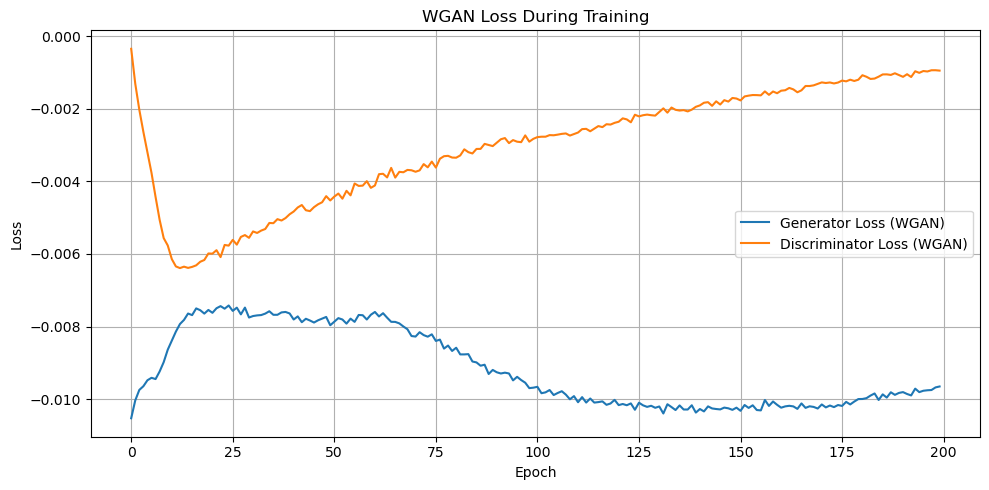

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(g_losses_wgan, label="Generator Loss (WGAN)")
plt.plot(d_losses_wgan, label="Discriminator Loss (WGAN)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("WGAN Loss During Training")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("wgan_loss_curve.png")
plt.show()


This WGAN training curve shows stable and gradual learning. The generator loss (blue) stays consistently negative and trends slightly downward, while the discriminator loss (orange) rises smoothly toward zero. These trends indicate good convergence without instability, which is a sign of healthy WGAN training

## <span style="color: #00509e;">Generate WGAN Synthetic Samples  </span>

In [41]:
# Generate synthetic data from WGAN
z = torch.randn(4000, latent_dim)
wgan_synthetic_samples = generator_wgan(z).detach().numpy()
wgan_original_scale = scaler.inverse_transform(wgan_synthetic_samples)

# View summary statistics
pd.DataFrame(wgan_original_scale, columns=minority_df.columns).describe()



,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,63.909782,0.176461,0.209058,0.849287,1.890977,129.132187,29.883610,1.482148
std,4.116282,0.057625,0.056311,0.049388,0.251567,12.896679,2.565944,0.183904
min,50.276264,0.034310,0.054671,0.668062,1.096947,85.574638,21.893940,0.895629
25%,61.053971,0.133734,0.168465,0.816825,1.724888,120.345253,28.097697,1.356911
50%,63.990053,0.173022,0.206113,0.852738,1.894646,129.505898,29.923388,1.486137
75%,66.784737,0.216260,0.247339,0.884436,2.058318,138.239540,31.625686,1.607664
max,77.211609,0.386240,0.415375,0.975454,2.787151,167.864548,38.530838,2.086403


# <span style="color:blue">CGAN</span>

## <span style="color: #00509e;">Define CGAN Generator and Discriminator  </span>

In [42]:
class CGANGenerator(nn.Module):
    def __init__(self):
        super(CGANGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim + 1, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()
        )

    def forward(self, noise, labels):
        x = torch.cat([noise, labels], dim=1)
        return self.model(x)

class CGANDiscriminator(nn.Module):
    def __init__(self):
        super(CGANDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim + 1, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, data, labels):
        x = torch.cat([data, labels], dim=1)
        return self.model(x)


## <span style="color: #00509e;">Initialize Models and Optimizers  </span>

In [43]:
generator_cgan = CGANGenerator()
discriminator_cgan = CGANDiscriminator()

criterion = nn.BCELoss()
lr = 0.0002

optimizer_g_cgan = torch.optim.Adam(generator_cgan.parameters(), lr=lr)
optimizer_d_cgan = torch.optim.Adam(discriminator_cgan.parameters(), lr=lr)


## <span style="color: #00509e;">Train CGAN  </span>

In [44]:
import matplotlib.pyplot as plt

# Initialize lists to store losses
g_losses_cgan = []
d_losses_cgan = []

epochs = 200

for epoch in range(epochs):
    total_d_loss = 0.0
    total_g_loss = 0.0
    batch_count = 0

    for real_batch, in data_loader:
        batch_size = real_batch.size(0)
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        # Condition = class label 1 (stroke)
        y = torch.ones(batch_size, 1)

        #  Train Discriminator 
        outputs_real = discriminator_cgan(real_batch, y)
        d_loss_real = criterion(outputs_real, real_labels)

        z = torch.randn(batch_size, latent_dim)
        fake_data = generator_cgan(z, y)
        outputs_fake = discriminator_cgan(fake_data.detach(), y)
        d_loss_fake = criterion(outputs_fake, fake_labels)

        d_loss = d_loss_real + d_loss_fake

        optimizer_d_cgan.zero_grad()
        d_loss.backward()
        optimizer_d_cgan.step()

        #  Train Generator 
        z = torch.randn(batch_size, latent_dim)
        fake_data = generator_cgan(z, y)
        outputs = discriminator_cgan(fake_data, y)
        g_loss = criterion(outputs, real_labels)

        optimizer_g_cgan.zero_grad()
        g_loss.backward()
        optimizer_g_cgan.step()

        # Accumulate losses for the batch
        total_d_loss += d_loss.item()
        total_g_loss += g_loss.item()
        batch_count += 1

    # Average loss for the epoch
    avg_d_loss = total_d_loss / batch_count
    avg_g_loss = total_g_loss / batch_count
    d_losses_cgan.append(avg_d_loss)
    g_losses_cgan.append(avg_g_loss)

    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], d_loss: {avg_d_loss:.4f}, g_loss: {avg_g_loss:.4f}")


Epoch [20/200], d_loss: 1.3306, g_loss: 0.7066
Epoch [40/200], d_loss: 1.3376, g_loss: 0.7113
Epoch [60/200], d_loss: 1.3881, g_loss: 0.6914
Epoch [80/200], d_loss: 1.3198, g_loss: 0.7367
Epoch [100/200], d_loss: 1.3757, g_loss: 0.7223
Epoch [120/200], d_loss: 1.2910, g_loss: 0.7594
Epoch [140/200], d_loss: 1.3269, g_loss: 0.7238
Epoch [160/200], d_loss: 1.3363, g_loss: 0.7124
Epoch [180/200], d_loss: 1.2676, g_loss: 0.7520
Epoch [200/200], d_loss: 1.3639, g_loss: 0.7211


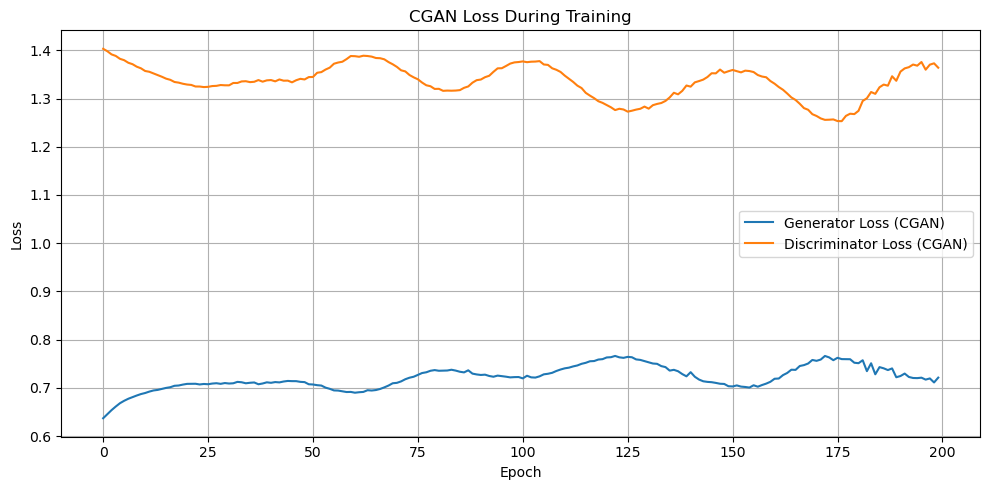

In [45]:
plt.figure(figsize=(10, 5))
plt.plot(g_losses_cgan, label="Generator Loss (CGAN)")
plt.plot(d_losses_cgan, label="Discriminator Loss (CGAN)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CGAN Loss During Training")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("cgan_loss_curve.png")
plt.show()


This loss curve shows the training progress of a Conditional GAN (CGAN) over 200 epochs.
The generator loss remains relatively stable around 0.7, while the discriminator loss oscillates around 1.3–1.4, indicating a balanced adversarial training.
These patterns suggest the CGAN is training reasonably well without major signs of collapse or domination by either network.

## <span style="color: #00509e;">Generate CGAN Synthetic Samples  </span>

In [46]:
z = torch.randn(4000, latent_dim)
y = torch.ones(4000, 1)  # Condition: stroke = 1
cgan_samples = generator_cgan(z, y).detach().numpy()
cgan_original_scale = scaler.inverse_transform(cgan_samples)

# Inspect generated samples
pd.DataFrame(cgan_original_scale, columns=minority_df.columns).describe()


,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,72.716965,0.126590,0.137809,0.873479,3.111670,97.617592,30.425362,1.987562
std,5.828032,0.099794,0.075980,0.049330,0.498287,29.212729,5.210702,0.565535
min,50.819897,0.000679,0.003085,0.680983,1.572455,56.460472,18.322399,0.239917
25%,68.935545,0.046205,0.078511,0.842463,2.762914,73.881735,26.545204,1.578296
50%,73.732189,0.100975,0.126489,0.876745,3.179125,91.234169,30.181739,2.052512
75%,77.445070,0.184453,0.188991,0.910139,3.517617,116.850473,34.059571,2.445383
max,81.831055,0.534098,0.435998,0.989349,3.984101,195.790497,46.157448,2.973768


## <span style="color: #00509e;">Using the generated data from tha GAN's to balance the original dataset  </span>

In [48]:
# Convert all to DataFrames and inverse scale
majority_df = df[df['stroke'] == 0].copy()
real_minority_df = df[df['stroke'] == 1].copy()
vanilla_df = pd.DataFrame(scaler.inverse_transform(synthetic_samples), columns=real_minority_df.columns.drop('stroke', errors='ignore'))
wgan_df = pd.DataFrame(scaler.inverse_transform(wgan_synthetic_samples), columns=real_minority_df.columns.drop('stroke', errors='ignore'))
cgan_df = pd.DataFrame(scaler.inverse_transform(cgan_samples), columns=real_minority_df.columns.drop('stroke', errors='ignore'))


# Add label
real_minority_df['stroke'] = 1
vanilla_df['stroke'] = 1
wgan_df['stroke'] = 1
cgan_df['stroke'] = 1

# Combine real + synthetic for each model
vanilla_minority_full = pd.concat([real_minority_df.drop(['stroke'], axis=1), vanilla_df], ignore_index=True)
wgan_minority_full = pd.concat([real_minority_df.drop(['stroke'], axis=1), wgan_df], ignore_index=True)
cgan_minority_full = pd.concat([real_minority_df.drop(['stroke'], axis=1), cgan_df], ignore_index=True)

# Add back the label
vanilla_minority_full['stroke'] = 1
wgan_minority_full['stroke'] = 1
cgan_minority_full['stroke'] = 1

# Combine with majority class
vanilla_balanced = pd.concat([majority_df, vanilla_minority_full], ignore_index=True)
wgan_balanced = pd.concat([majority_df, wgan_minority_full], ignore_index=True)
cgan_balanced = pd.concat([majority_df, cgan_minority_full], ignore_index=True)

# Shuffle datasets
vanilla_balanced = shuffle(vanilla_balanced, random_state=42)
wgan_balanced = shuffle(wgan_balanced, random_state=42)
cgan_balanced = shuffle(cgan_balanced, random_state=42)

print("vanilla_balanced",vanilla_balanced  ['stroke'].value_counts())
print("wgan_balanced",wgan_balanced ['stroke'].value_counts())
print("cgan_balanced",cgan_balanced  ['stroke'].value_counts())

vanilla_balanced stroke
0    4700
1    4209
Name: count, dtype: int64
wgan_balanced stroke
0    4700
1    4209
Name: count, dtype: int64
cgan_balanced stroke
0    4700
1    4209
Name: count, dtype: int64


## <span style="color: #00509e;">MLP classifier for origional imbalance data   </span>

split the data 70 / 30 

In [49]:
if 'stroke' in df.columns:
    X = df.drop(columns=['stroke'])
    y = df['stroke']
# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify= y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

# Display shape of data after preparation
print(f"Training set shape: {X_train.shape}, Validation set shape: {X_val.shape}, Test set shape: {X_test.shape}")
X_train.head()

Training set shape: (3436, 8), Validation set shape: (736, 8), Test set shape: (737, 8)


,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status
552,52.00,0,0,1,2,247.69,35.1,0
1486,1.88,0,0,0,4,111.65,16.3,0
849,70.00,1,0,1,3,99.60,34.3,1
4314,45.00,0,0,1,3,110.10,30.9,2
1284,31.00,0,0,1,2,100.39,37.0,2



Stroke distribution:


stroke
0    4700
1     209
Name: count, dtype: int64

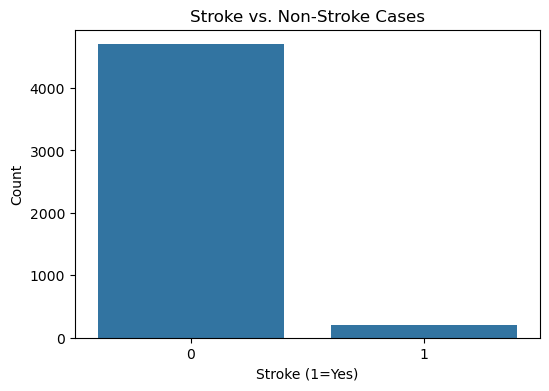

In [50]:
print("\nStroke distribution:")
stroke_counts = df['stroke'].value_counts()
display(stroke_counts)
plt.figure(figsize=(6,4))
sns.barplot(x=stroke_counts.index, y=stroke_counts.values)
plt.title('Stroke vs. Non-Stroke Cases')
plt.xlabel('Stroke (1=Yes)')
plt.ylabel('Count')
plt.show()

In [51]:
#  Scale features (normalization)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [74]:
#  hyperparameter tuning with grid search
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)], # Try different layer sizes
    'activation': ['relu', 'logistic'], # Test different activation functions
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001],  # Regularization strength
    'learning_rate': ['constant', 'adaptive'] , # Experiment with learning rate
    'batch_size': [50, 100, 200], # Test different batch sizes
    'max_iter': [500, 1000],  # More iterations to check for convergence

}

grid = GridSearchCV(MLPClassifier(max_iter=300, random_state=42),
                    param_grid,
                    cv=3,
                    scoring='f1',
                    n_jobs=-1)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

Best Parameters: {'activation': 'relu', 'alpha': 0.001, 'batch_size': 100, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'max_iter': 500, 'solver': 'adam'}


Performing hyperparameter tuning for the MLP classifier using GridSearchCV with 3-fold cross-validation.

It searches for the best combination of parameters from the defined 'param_grid'.

The 'n_jobs=-1' utilizes all available processors for parallel computation.

Creating a Multi-Layer Perceptron (MLP) classifier with the Adam optimizer and a fixed random seed (random_state=42). The MLP model will be used for classification tasks.

In [75]:
#  Create and train the MLP model with logostic activation function
mlp = MLPClassifier(hidden_layer_sizes=(100,50),learning_rate= 'constant', max_iter=500, activation='relu',alpha= 0.001, solver='adam',batch_size= 100, random_state=42)
mlp.fit(X_train, y_train)

#  Make predictions on the test set
y_pred = mlp.predict(X_test)

# - Accuracy: Proportion of correct predictions.
# - Precision: The ratio of true positive predictions to the total predicted positives (macro average).
# - Recall: The ratio of true positive predictions to the total actual positives (macro average).
# - F1-Score: The harmonic mean of precision and recall (macro average).
#  Evaluate model performance 
accuracy = accuracy_score(y_test, y_pred)
error_percentage = (1 - accuracy) * 100

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Error Percentage: {error_percentage:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 93.49%
Error Percentage: 6.51%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       705
           1       0.06      0.03      0.04        32

    accuracy                           0.93       737
   macro avg       0.51      0.50      0.50       737
weighted avg       0.92      0.93      0.93       737



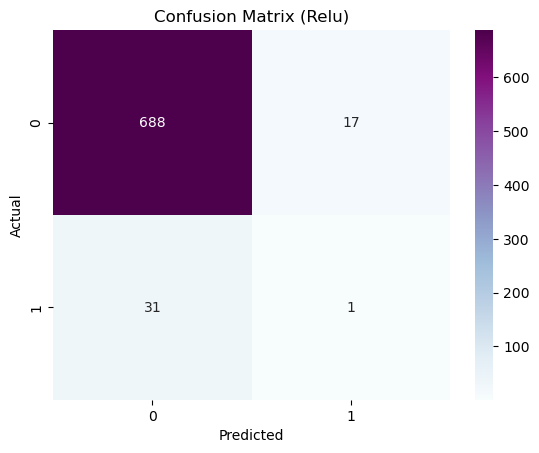

In [76]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu')
plt.title('Confusion Matrix (Relu)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

here we see that this model biases towareds the class 0

## <span style="color: #00509e;">MLP classifier for vanilla GAN data   </span>

In [77]:
if 'stroke' in vanilla_balanced.columns:
    X_v = vanilla_balanced.drop(columns=['stroke'])
    y_v = vanilla_balanced['stroke']
# Split into training, validation, and test sets
X_Vtrain, X_Vtemp, y_Vtrain, y_Vtemp = train_test_split(X_v, y_v, test_size=0.30, random_state=42, stratify= y_v)
X_Vval, X_Vtest, y_Vval, y_Vtest = train_test_split(X_Vtemp, y_Vtemp, test_size=0.50, random_state=42, stratify=y_Vtemp)

# Display shape of data after preparation
print(f"Training set shape: {X_Vtrain.shape}, Validation set shape: {X_Vval.shape}, Test set shape: {X_Vtest.shape}")
X_Vtrain.head()

Training set shape: (6236, 8), Validation set shape: (1336, 8), Test set shape: (1337, 8)


,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status
897,78.000000,0.000000,0.000000,0.000000,2.000000,67.960000,26.800000,0.000000
5932,80.987122,0.977854,0.111548,0.994918,3.210758,180.144058,19.889240,0.153630
7861,55.479160,0.036204,0.664090,0.952808,0.812194,211.003723,37.664539,2.317225
5982,72.920776,0.872993,0.212008,0.967096,2.352280,158.916306,26.575785,0.485048
6353,65.251030,0.015402,0.321141,0.990886,0.928300,151.700394,37.280304,1.752182



Stroke distribution:


stroke
0    4700
1    4209
Name: count, dtype: int64

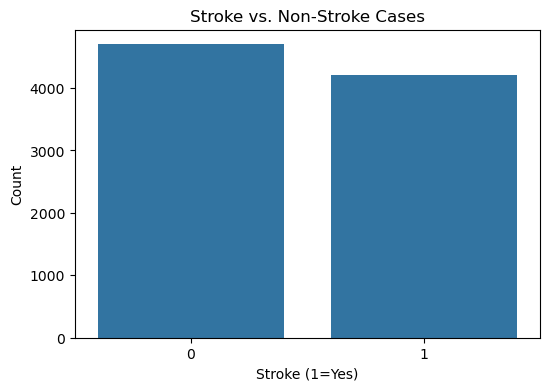

In [78]:
print("\nStroke distribution:")
stroke_counts = vanilla_balanced['stroke'].value_counts()
display(stroke_counts)
plt.figure(figsize=(6,4))
sns.barplot(x=stroke_counts.index, y=stroke_counts.values)
plt.title('Stroke vs. Non-Stroke Cases')
plt.xlabel('Stroke (1=Yes)')
plt.ylabel('Count')
plt.show()

we clearly see here that the vanilla gan balanced the data with generating 4000 sample of class 1

In [79]:
#  Scale features (normalization)
scaler = StandardScaler()
X_Vtrain = scaler.fit_transform(X_Vtrain)
X_Vtest = scaler.transform(X_Vtest)
X_Vval = scaler.transform(X_Vval)

In [80]:
#  hyperparameter tuning with grid search
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)], # Try different layer sizes
    'activation': ['relu', 'logistic'], # Test different activation functions
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001],  # Regularization strength
    'learning_rate': ['constant', 'adaptive'] , # Experiment with learning rate
    'batch_size': [50, 100, 200], # Test different batch sizes
    'max_iter': [500, 1000],  # More iterations to check for convergence

}

grid = GridSearchCV(MLPClassifier(max_iter=300, random_state=42),
                    param_grid,
                    cv=3,
                    scoring='f1',
                    n_jobs=-1)

grid.fit(X_Vtrain, y_Vtrain)
best_model = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

Best Parameters: {'activation': 'logistic', 'alpha': 0.0001, 'batch_size': 200, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 500, 'solver': 'adam'}


In [81]:
#  Create and train the MLP model with logistis activation function
V_mlp = MLPClassifier(hidden_layer_sizes=(100,),learning_rate= 'constant', max_iter=500, activation='logistic',alpha= 0.0001, solver='adam',batch_size= 200, random_state=42)
V_mlp.fit(X_Vtrain, y_Vtrain)

#  Make predictions on the test set
y_Vpred = V_mlp.predict(X_Vtest)

# - Accuracy: Proportion of correct predictions.
# - Precision: The ratio of true positive predictions to the total predicted positives (macro average).
# - Recall: The ratio of true positive predictions to the total actual positives (macro average).
# - F1-Score: The harmonic mean of precision and recall (macro average).
#  Evaluate model performance 
V_accuracy = accuracy_score(y_Vtest, y_Vpred)
V_error_percentage = (1 - V_accuracy) * 100

print(f"Accuracy: {V_accuracy * 100:.2f}%")
print(f"Error Percentage: {V_error_percentage:.2f}%")

print("\nClassification Report:")
print(classification_report(y_Vtest, y_Vpred))

Accuracy: 97.16%
Error Percentage: 2.84%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       705
           1       0.99      0.95      0.97       632

    accuracy                           0.97      1337
   macro avg       0.97      0.97      0.97      1337
weighted avg       0.97      0.97      0.97      1337



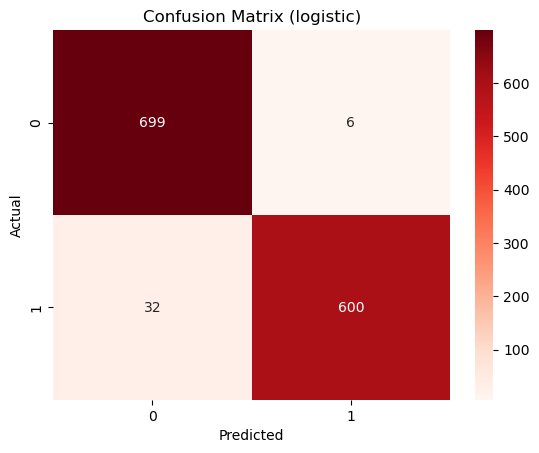

In [89]:
V_cm = confusion_matrix(y_Vtest, y_Vpred)
sns.heatmap(V_cm, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix (logistic)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## <span style="color: #00509e;">MLP classifier for WGAN data   </span>

In [83]:
if 'stroke' in wgan_balanced.columns:
    X_w = wgan_balanced.drop(columns=['stroke'])
    y_w = wgan_balanced['stroke']
# Split into training, validation, and test sets
X_Wtrain, X_Wtemp, y_Wtrain, y_Wtemp = train_test_split(X_w, y_w, test_size=0.30, random_state=42, stratify= y_w)
X_Wval, X_Wtest, y_Wval, y_Wtest = train_test_split(X_Wtemp, y_Wtemp, test_size=0.50, random_state=42, stratify=y_Wtemp)

# Display shape of data after preparation
print(f"Training set shape: {X_Wtrain.shape}, Validation set shape: {X_Wval.shape}, Test set shape: {X_Wtest.shape}")
X_Wtrain.head()

Training set shape: (6236, 8), Validation set shape: (1336, 8), Test set shape: (1337, 8)


,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status
897,78.000000,0.000000,0.000000,0.000000,2.000000,67.960000,26.800000,0.000000
5932,65.058716,0.155330,0.295358,0.825014,1.685403,139.912537,28.686453,1.350552
7861,70.084702,0.113908,0.162422,0.897058,1.492296,127.048622,27.166063,1.742420
5982,64.982689,0.245455,0.297593,0.824384,2.042303,126.222809,34.542332,1.283102
6353,65.690804,0.093821,0.183175,0.919475,2.358326,122.435638,30.085140,1.166595



Stroke distribution:


stroke
0    4700
1    4209
Name: count, dtype: int64

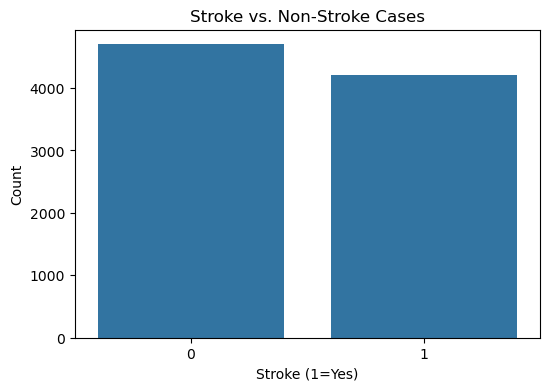

In [84]:
print("\nStroke distribution:")
stroke_counts = wgan_balanced['stroke'].value_counts()
display(stroke_counts)
plt.figure(figsize=(6,4))
sns.barplot(x=stroke_counts.index, y=stroke_counts.values)
plt.title('Stroke vs. Non-Stroke Cases')
plt.xlabel('Stroke (1=Yes)')
plt.ylabel('Count')
plt.show()

we clearly see here that the wgan balanced the data with generating 4000 sample of class 1

In [85]:
#  Scale features (normalization)
scaler = StandardScaler()
X_Wtrain = scaler.fit_transform(X_Wtrain)
X_Wtest = scaler.transform(X_Wtest)
X_Wval = scaler.transform(X_Wval)

In [86]:
#  hyperparameter tuning with grid search
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)], # Try different layer sizes
    'activation': ['relu', 'logistic'], # Test different activation functions
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001],  # Regularization strength
    'learning_rate': ['constant', 'adaptive'] , # Experiment with learning rate
    'batch_size': [50, 100, 200], # Test different batch sizes
    'max_iter': [500, 1000],  # More iterations to check for convergence

}

grid = GridSearchCV(MLPClassifier(max_iter=300, random_state=42),
                    param_grid,
                    cv=3,
                    scoring='f1',
                    n_jobs=-1)

grid.fit(X_Wtrain, y_Wtrain)
best_model = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

Best Parameters: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 100, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'adaptive', 'max_iter': 500, 'solver': 'sgd'}


In [87]:
#  Create and train the MLP model with relu activation function
W_mlp = MLPClassifier(hidden_layer_sizes=(100,50),learning_rate= 'constant', max_iter=500, activation='relu',alpha= 0.0001, solver='adam',batch_size= 100, random_state=42)
W_mlp.fit(X_Wtrain, y_Wtrain)

#  Make predictions on the test set
y_Wpred = W_mlp.predict(X_Wtest)

# - Accuracy: Proportion of correct predictions.
# - Precision: The ratio of true positive predictions to the total predicted positives (macro average).
# - Recall: The ratio of true positive predictions to the total actual positives (macro average).
# - F1-Score: The harmonic mean of precision and recall (macro average).
#  Evaluate model performance 
W_accuracy = accuracy_score(y_Wtest, y_Wpred)
W_error_percentage = (1 - W_accuracy) * 100

print(f"Accuracy: {W_accuracy * 100:.2f}%")
print(f"Error Percentage: {W_error_percentage:.2f}%")

print("\nClassification Report:")
print(classification_report(y_Wtest, y_Wpred))

Accuracy: 96.63%
Error Percentage: 3.37%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       705
           1       0.98      0.95      0.96       632

    accuracy                           0.97      1337
   macro avg       0.97      0.97      0.97      1337
weighted avg       0.97      0.97      0.97      1337



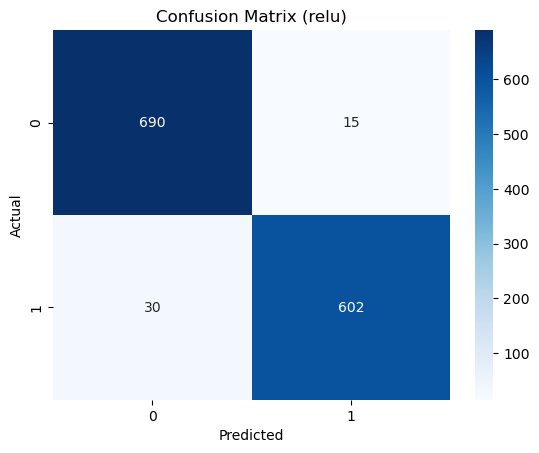

In [88]:
W_cm = confusion_matrix(y_Wtest, y_Wpred)
sns.heatmap(W_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (relu)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## <span style="color: #00509e;">MLP classifier for CGAN data   </span>

In [90]:
if 'stroke' in cgan_balanced.columns:
    X_c = cgan_balanced.drop(columns=['stroke'])
    y_c = cgan_balanced['stroke']
# Split into training, validation, and test sets
X_Ctrain, X_Ctemp, y_Ctrain, y_Ctemp = train_test_split(X_c, y_c, test_size=0.30, random_state=42, stratify= y_c)
X_Cval, X_Ctest, y_Cval, y_Ctest = train_test_split(X_Ctemp, y_Ctemp, test_size=0.50, random_state=42, stratify=y_Ctemp)

# Display shape of data after preparation
print(f"Training set shape: {X_Ctrain.shape}, Validation set shape: {X_Cval.shape}, Test set shape: {X_Ctest.shape}")
X_Ctrain.head()

Training set shape: (6236, 8), Validation set shape: (1336, 8), Test set shape: (1337, 8)


,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status
897,78.000000,0.000000,0.000000,0.000000,2.000000,67.960000,26.800000,0.000000
5932,62.046223,0.328871,0.240451,0.858275,2.638661,144.959641,37.984005,1.694778
7861,67.704903,0.340358,0.227298,0.759769,2.545871,158.953537,39.167046,1.684159
5982,63.651966,0.364911,0.192061,0.871840,2.260746,178.557877,37.828728,1.228180
6353,72.648033,0.103668,0.208306,0.816896,2.474745,122.406975,32.276520,1.612481



Stroke distribution:


stroke
0    4700
1    4209
Name: count, dtype: int64

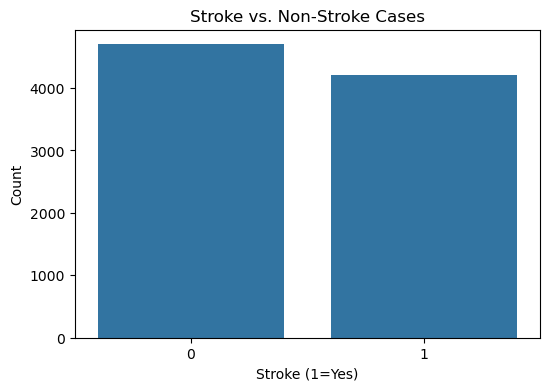

In [91]:
print("\nStroke distribution:")
stroke_counts = cgan_balanced['stroke'].value_counts()
display(stroke_counts)
plt.figure(figsize=(6,4))
sns.barplot(x=stroke_counts.index, y=stroke_counts.values)
plt.title('Stroke vs. Non-Stroke Cases')
plt.xlabel('Stroke (1=Yes)')
plt.ylabel('Count')
plt.show()

we clearly see here that the cgan balanced the data with generating 4000 sample of class 1

In [92]:
#  Scale features (normalization)
scaler = StandardScaler()
X_Ctrain = scaler.fit_transform(X_Ctrain)
X_Ctest = scaler.transform(X_Ctest)
X_Cval = scaler.transform(X_Cval)

In [93]:
#  hyperparameter tuning with grid search
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)], # Try different layer sizes
    'activation': ['relu', 'logistic'], # Test different activation functions
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001],  # Regularization strength
    'learning_rate': ['constant', 'adaptive'] , # Experiment with learning rate
    'batch_size': [50, 100, 200], # Test different batch sizes
    'max_iter': [500, 1000],  # More iterations to check for convergence

}

grid = GridSearchCV(MLPClassifier(max_iter=300, random_state=42),
                    param_grid,
                    cv=3,
                    scoring='f1',
                    n_jobs=-1)

grid.fit(X_Ctrain, y_Ctrain)
best_model = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

Best Parameters: {'activation': 'logistic', 'alpha': 0.001, 'batch_size': 50, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'max_iter': 500, 'solver': 'adam'}


In [94]:
#  Create and train the MLP model with logostic activation function
C_mlp = MLPClassifier(hidden_layer_sizes=(100,50),learning_rate= 'constant', max_iter=500, activation='logistic',alpha= 0.001, solver='adam',batch_size= 50, random_state=42)
C_mlp.fit(X_Ctrain, y_Ctrain)

#  Make predictions on the test set
y_Cpred = C_mlp.predict(X_Ctest)

# - Accuracy: Proportion of correct predictions.
# - Precision: The ratio of true positive predictions to the total predicted positives (macro average).
# - Recall: The ratio of true positive predictions to the total actual positives (macro average).
# - F1-Score: The harmonic mean of precision and recall (macro average).
#  Evaluate model performance 
C_accuracy = accuracy_score(y_Ctest, y_Cpred)
C_error_percentage = (1 - C_accuracy) * 100

print(f"Accuracy: {C_accuracy * 100:.2f}%")
print(f"Error Percentage: {C_error_percentage:.2f}%")

print("\nClassification Report:")
print(classification_report(y_Ctest, y_Cpred))

Accuracy: 97.38%
Error Percentage: 2.62%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       705
           1       1.00      0.95      0.97       632

    accuracy                           0.97      1337
   macro avg       0.98      0.97      0.97      1337
weighted avg       0.97      0.97      0.97      1337



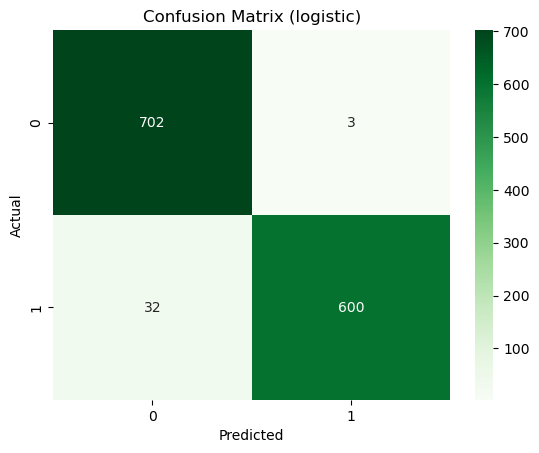

In [95]:
C_cm = confusion_matrix(y_Ctest, y_Cpred)
sns.heatmap(C_cm, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix (logistic)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [96]:

# Create a dictionary to store results
results = {
    'Model': [],
    'Accuracy': [],
    'Precision ': [],
    'Recall ': [],
    'F1-Score ': []
}

# Helper function to extract macro avg from classification report
def extract_metrics(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, output_dict=True)
    accuracy = accuracy_score(y_true, y_pred)
    precision = report['macro avg']['precision']
    recall = report['macro avg']['recall']
    f1 = report['macro avg']['f1-score']

    results['Model'].append(model_name)
    results['Accuracy'].append(accuracy)
    results['Precision '].append(precision)
    results['Recall '].append(recall)
    results['F1-Score '].append(f1)

# Extract metrics for all 4 models
extract_metrics(y_test, y_pred, "Origional")
extract_metrics(y_Vtest, y_Vpred, "Vanilla GAN")
extract_metrics(y_Wtest, y_Wpred, "WGAN")
extract_metrics(y_Ctest, y_Cpred, "CGAN")

# Create DataFrame
df_results = pd.DataFrame(results)

# Style the table
styled_table = df_results.style\
    .background_gradient(subset=['Accuracy', 'Precision ', 'Recall ', 'F1-Score '], cmap='BuPu')\
    .format("{:.2%}", subset=['Accuracy', 'Precision ', 'Recall ', 'F1-Score '])

styled_table


,Model,Accuracy,Precision,Recall,F1-Score
0,Origional,93.49%,50.62%,50.36%,50.31%
1,Vanilla GAN,97.16%,97.32%,97.04%,97.14%
2,WGAN,96.63%,96.70%,96.56%,96.62%
3,CGAN,97.38%,97.57%,97.26%,97.37%


frome these results we can see how the gan's improved the classifier performance specially the cgan 

## <span style="color: #00509e;">these histograms shows the distribution for the synthetic data   </span>

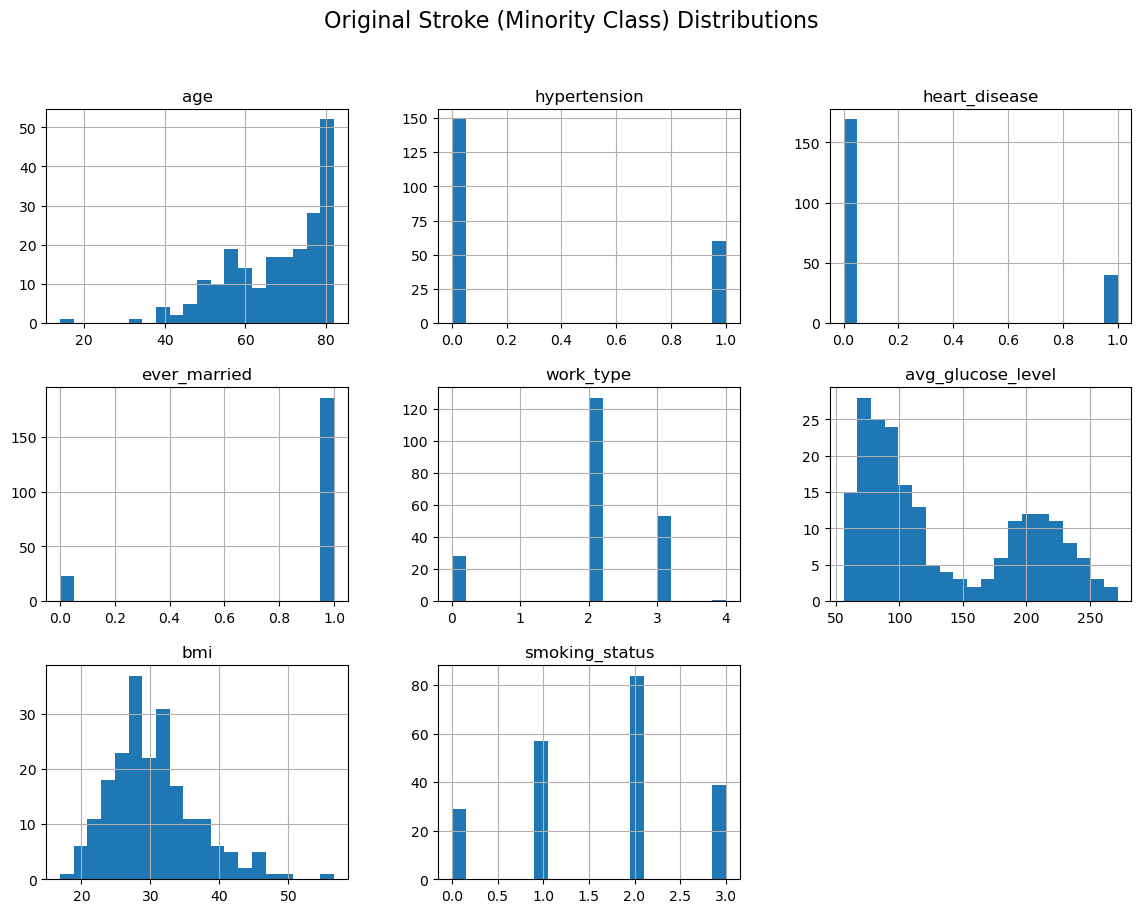

In [97]:
# Convert to DataFrame for plotting
original_df = pd.DataFrame(minority_df.values, columns=minority_df.columns)

# Plot distributions
original_df.hist(figsize=(14, 10), bins=20)
plt.suptitle("Original Stroke (Minority Class) Distributions", fontsize=16)
plt.show()

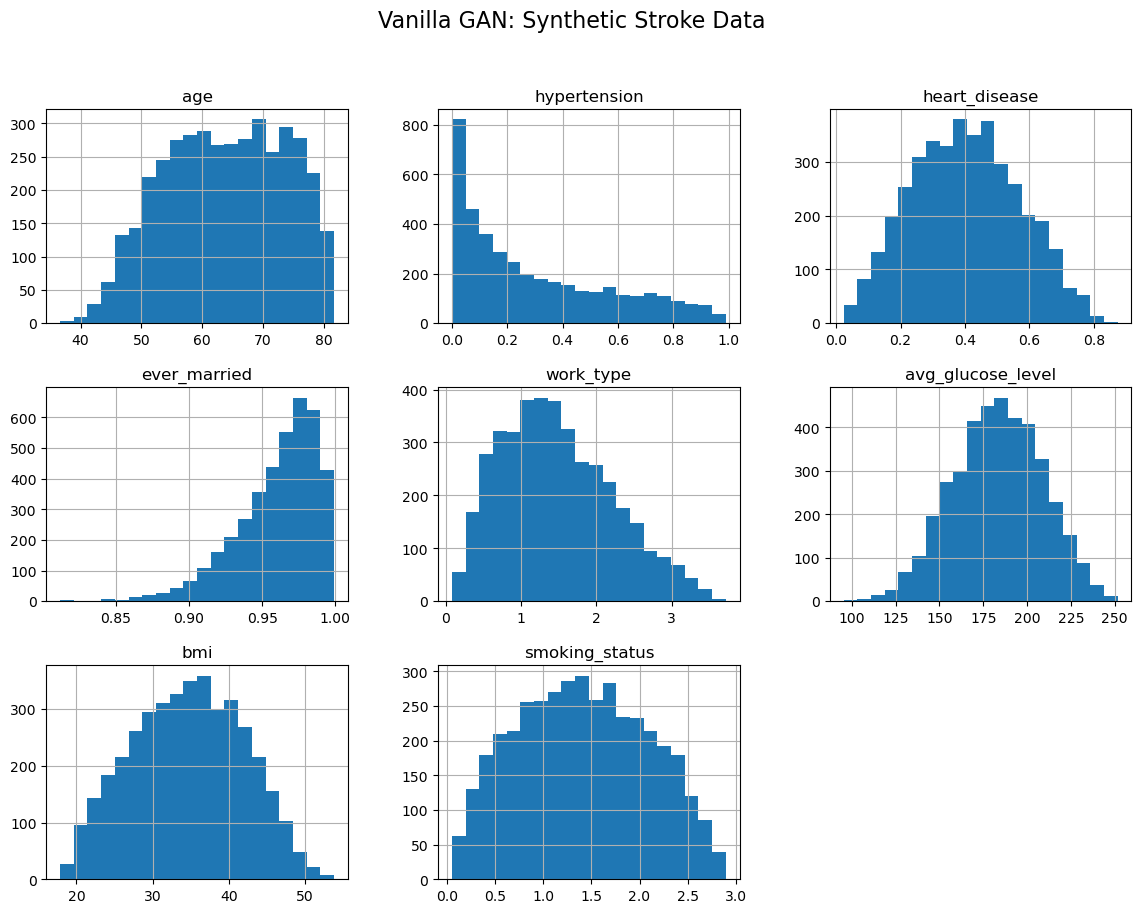

In [98]:
vanilla_df = pd.DataFrame(synthetic_original_scale, columns=minority_df.columns)

vanilla_df.hist(figsize=(14, 10), bins=20)
plt.suptitle("Vanilla GAN: Synthetic Stroke Data", fontsize=16)
plt.show()

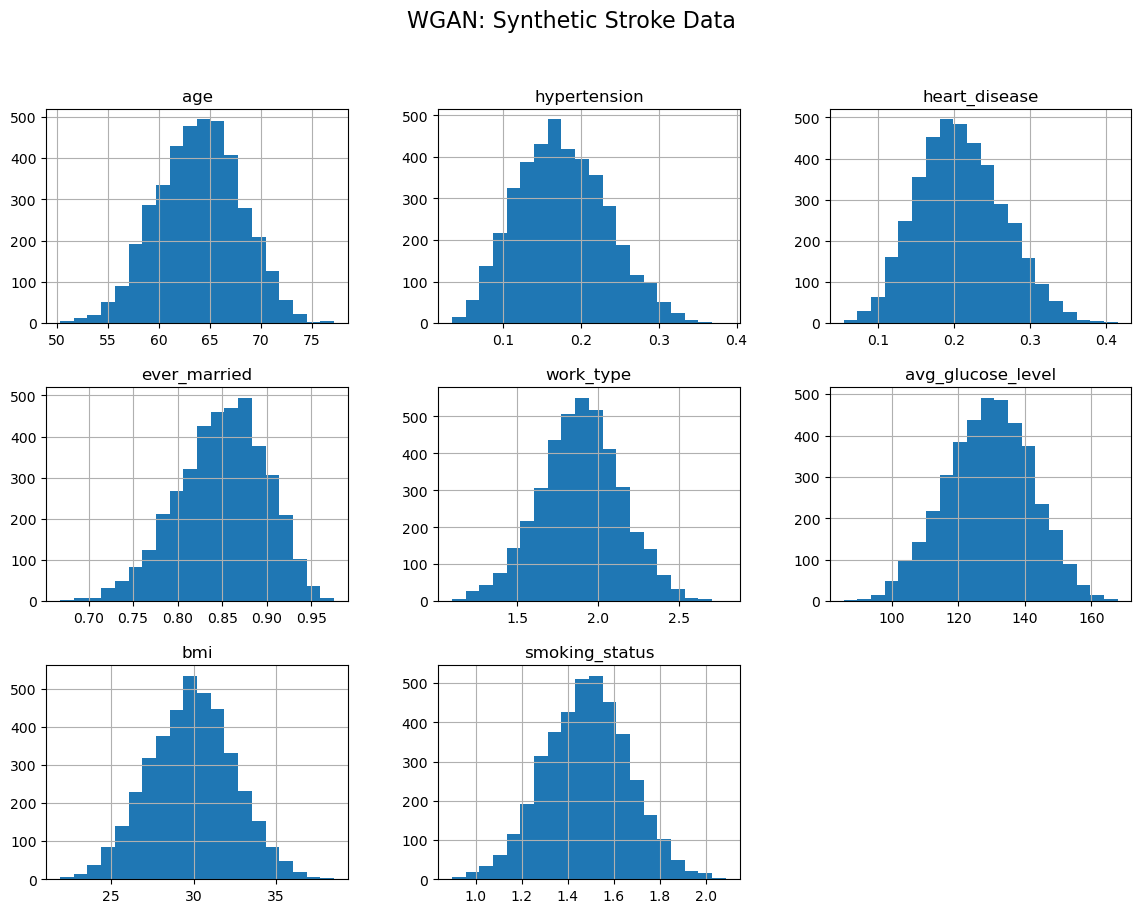

In [99]:
wgan_df = pd.DataFrame(wgan_original_scale, columns=minority_df.columns)

wgan_df.hist(figsize=(14, 10), bins=20)
plt.suptitle("WGAN: Synthetic Stroke Data", fontsize=16)
plt.show()

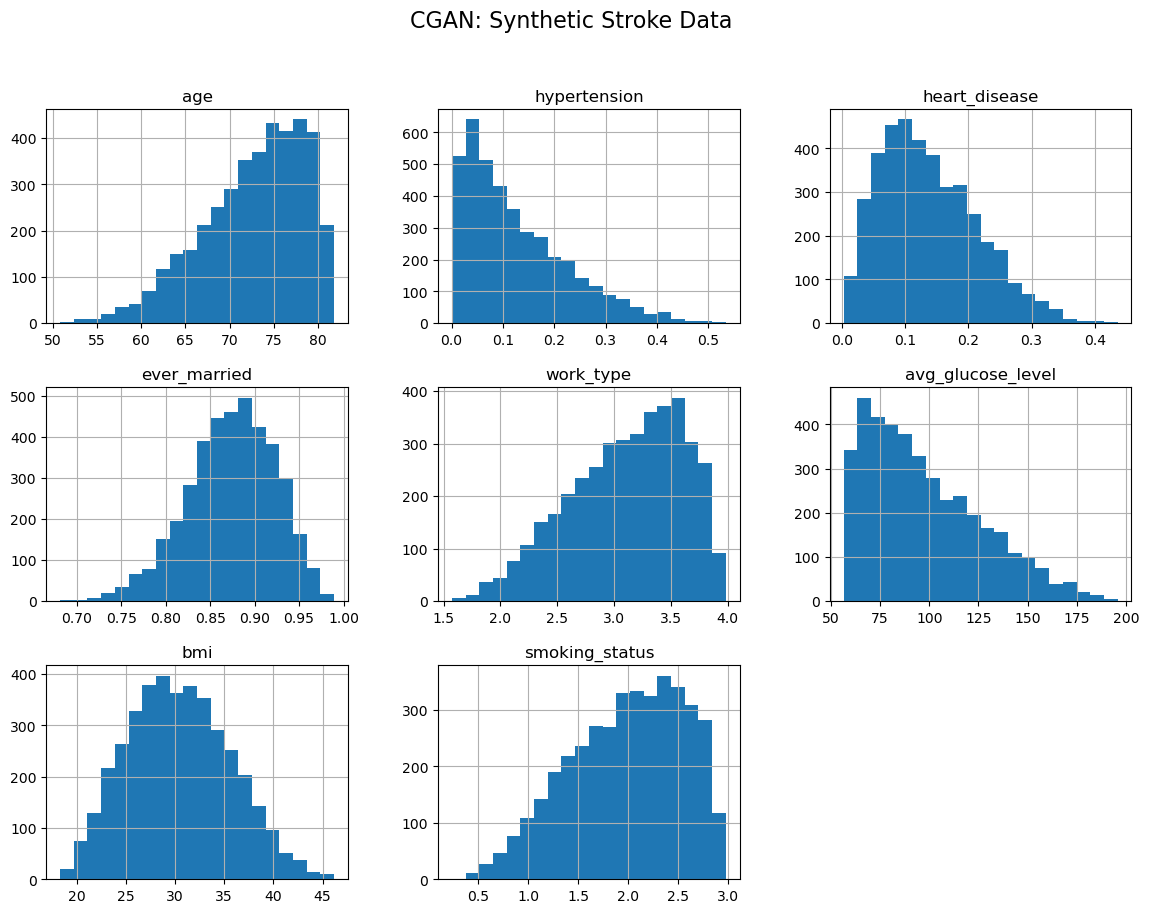

In [101]:
cgan_df = pd.DataFrame(cgan_original_scale, columns=minority_df.columns)

cgan_df.hist(figsize=(14, 10), bins=20)
plt.suptitle("CGAN: Synthetic Stroke Data", fontsize=16)
plt.show()